In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset
import matplotlib.pyplot as plt
from tqdm import tqdm


torch.set_grad_enabled(False)

/home/rseetharaman_umass_edu/.conda/envs/rome/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
model_name = "mistralai/Mistral-7B-v0.1" 
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
knowns = KnownsDataset(known_loc='augmented_mistral.jsonl')  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 43 elements
Using noise level 0.007710353471338749


In [5]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

#### Sanity check to ensure we are masking out the right span

In [8]:
def checker(prompt, subject):
    inp = make_inputs(mt.tokenizer, [prompt] * (10 + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    subject_start, subject_end = e_range
    decoded_range = mt.tokenizer.decode(inp['input_ids'][0][subject_start])
    # print(decoded_range, subject)
    assert decoded_range == subject

In [9]:
for knowledge in tqdm(knowns):
    checker(knowledge['prompt'], knowledge['subject'])

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:11<00:00,  3.72it/s]


In [11]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None,
    token_range=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise, token_range=token_range
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
            token_range=token_range
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1, token_range=None):
    ntoks = inp["input_ids"].shape[1]
    table = []
    subject_start, subject_end = e_range
    # print(f"Start: {subject_start}, End: {subject_end}")
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            if tnum>=subject_start:
                # if tnum == subject_start:
                    # print(inp['input_ids'].shape)
                    # print(mt.tokenizer.decode([inp['input_ids'][0][tnum]]))
                r = trace_with_patch(
                    model,
                    inp,
                    [(tnum, layername(model, layer))],
                    answer_t,
                    tokens_to_mix=e_range,
                    noise=noise,
                )
                # print(f"appending {r}")
                row.append(r)
            else:
                row.append(torch.tensor(0.0).to(device="cuda:0"))
            # print(f"The row is {row}")
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1, token_range=None,
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    subject_start, subject_end = e_range
    # print(f"Start: {subject_start}, End: {subject_end}")
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            if tnum>=subject_start:
                # if tnum == subject_start:
                    # print(inp['input_ids'].shape)
                    # print(mt.tokenizer.decode([inp['input_ids'][0][tnum]]))
                r = trace_with_patch(
                    model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
                )
                row.append(r)
            else:
                row.append(torch.tensor(0.0).to(device="cuda:0"))
        table.append(torch.stack(row))
    return torch.stack(table)

In [12]:
def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman", "font.size": 4}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=4)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()



def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    token_range=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, token_range=token_range
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None, token_range=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind, token_range=token_range
        )

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


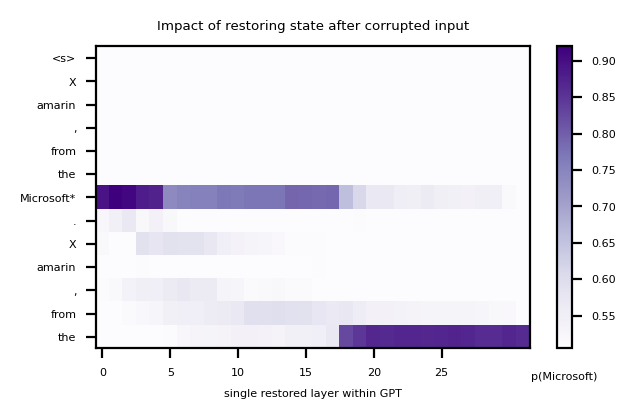

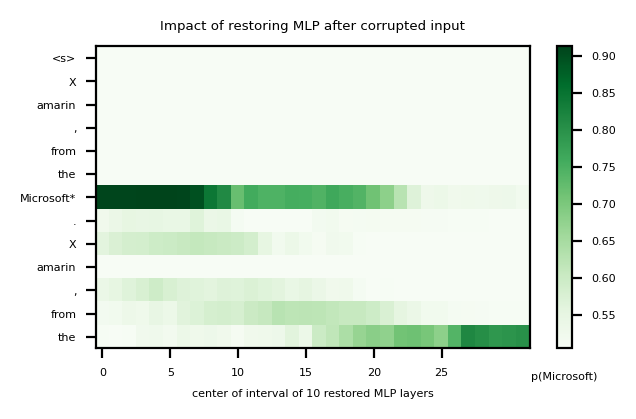

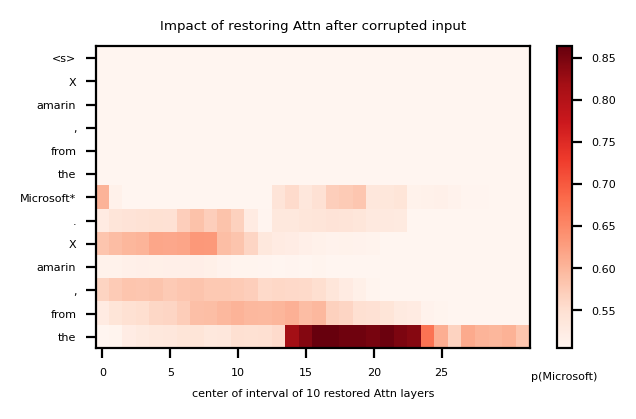

In [13]:
plot_all_flow(mt, knowns[0]["prompt"], knowns[0]['subject'], noise=noise_level)

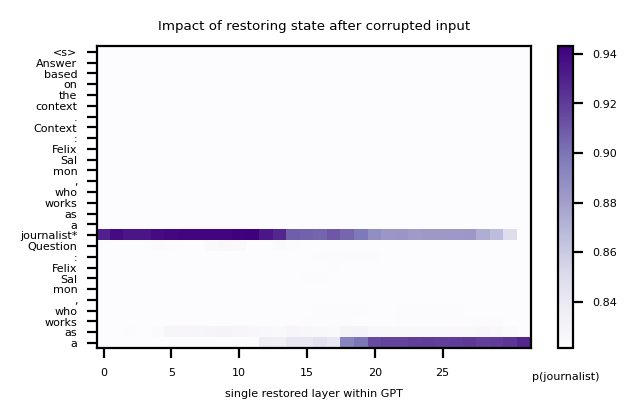

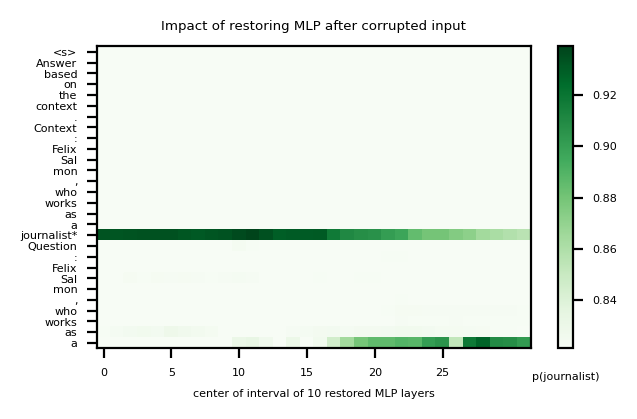

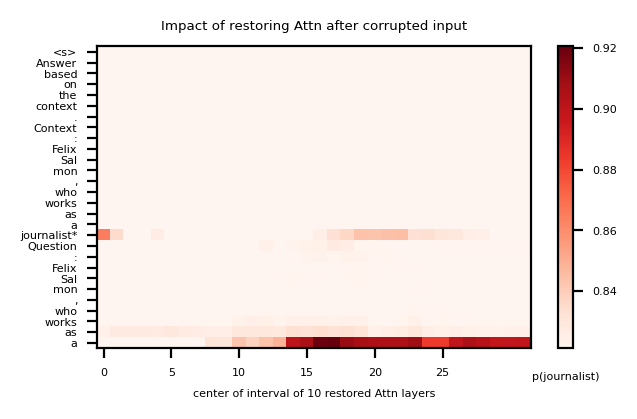

In [42]:
plot_all_flow(mt, knowns[2]["prompt"], knowns[2]['subject'], noise=noise_level)

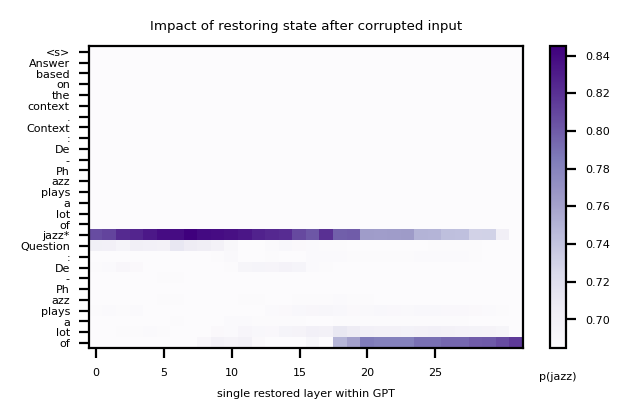

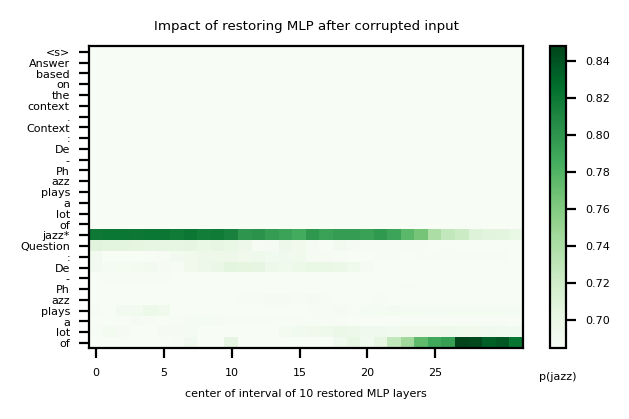

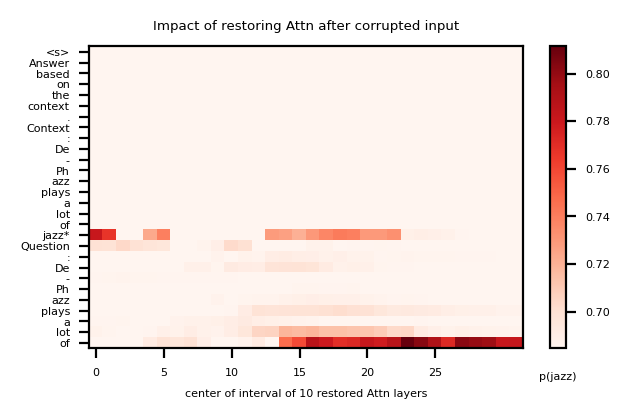

In [43]:
plot_all_flow(mt, knowns[5]["prompt"], knowns[5]['subject'], noise=noise_level)